# Quality of Life Scores Among Major U.S. Cities, Score Subset: Housing, Cost of Living, Travel Connectivity, Commute, Education

In [1]:
#import dependencies

import pandas as pd
import json
import numpy
import csv
import requests
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.stats as linregress
import gmaps
import os

In [2]:
# Import json of list of cities we want to use for group project

my_file = '../Share/city_data.json'
with open(my_file ,'r') as f:
    data = json.loads(f.read())
# Flatten data
cities_df = pd.json_normalize(data)


In [3]:
#Turn data into dataframe grouped by state

cities_df.columns

Index(['datasetid', 'recordid', 'record_timestamp', 'fields.elevation',
       'fields.name', 'fields.modification_date', 'fields.country',
       'fields.feature_class', 'fields.admin3_code', 'fields.alternate_names',
       'fields.feature_code', 'fields.longitude', 'fields.geoname_id',
       'fields.timezone', 'fields.dem', 'fields.country_code',
       'fields.ascii_name', 'fields.latitude', 'fields.admin1_code',
       'fields.coordinates', 'fields.admin2_code', 'fields.population',
       'geometry.type', 'geometry.coordinates'],
      dtype='object')

In [4]:
cities_df = cities_df[['fields.name', 'fields.admin1_code', 'fields.country_code', 'fields.population', 'fields.latitude', 'fields.longitude']]

In [5]:
cities_df = cities_df.rename(columns={'fields.name': 'City', 'fields.admin1_code': 'State', 'fields.country_code': 'Country',
       'fields.population': 'Population', 'fields.latitude': 'Latitude', 'fields.longitude': 'Longitude'})

In [6]:
city_grp = cities_df.groupby(['State'])

In [7]:
#We want to use one city per state, with largest population in each state as decided upon by our group

lgst_cities = city_grp.apply(lambda g: g[g['Population'] == g['Population'].max()])

In [8]:
lgst_cities = lgst_cities.reset_index(drop=True)
lgst_cities

,City,State,Country,Population,Latitude,Longitude
0,Anchorage,AK,US,298695,61.21806,-149.90028
1,Birmingham,AL,US,212461,33.52066,-86.80249
2,Little Rock,AR,US,197992,34.74648,-92.28959
3,Phoenix,AZ,US,1563025,33.44838,-112.07404
4,Los Angeles,CA,US,3971883,34.05223,-118.24368
5,Denver,CO,US,682545,39.73915,-104.9847
6,Bridgeport,CT,US,147629,41.17923,-73.18945
7,Washington,DC,US,601723,38.89511,-77.03637
8,Wilmington,DE,US,71948,39.74595,-75.54659
9,Jacksonville,FL,US,868031,30.33218,-81.65565


In [9]:
#Create collumns for our new data from our API showing quality of life ratings for the cities we pre-selected
new_cols = ['Housing', 'Cost of Living', 'Startups', 'Venture Capital', 'Travel Connectivity', 'Commute', 'Business Freedom', 'Safety', 'Healthcare', 'Education', 'Environmental Quality', 'Economy', 'Taxation', 'Internet Access', 'Leisure & Culture']
for col in new_cols:
    lgst_cities[col] = ""
lgst_cities

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Startups,Venture Capital,...,Commute,Business Freedom,Safety,Healthcare,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture
0,Anchorage,AK,US,298695,61.21806,-149.90028,,,,,...,,,,,,,,,,
1,Birmingham,AL,US,212461,33.52066,-86.80249,,,,,...,,,,,,,,,,
2,Little Rock,AR,US,197992,34.74648,-92.28959,,,,,...,,,,,,,,,,
3,Phoenix,AZ,US,1563025,33.44838,-112.07404,,,,,...,,,,,,,,,,
4,Los Angeles,CA,US,3971883,34.05223,-118.24368,,,,,...,,,,,,,,,,
5,Denver,CO,US,682545,39.73915,-104.9847,,,,,...,,,,,,,,,,
6,Bridgeport,CT,US,147629,41.17923,-73.18945,,,,,...,,,,,,,,,,
7,Washington,DC,US,601723,38.89511,-77.03637,,,,,...,,,,,,,,,,
8,Wilmington,DE,US,71948,39.74595,-75.54659,,,,,...,,,,,,,,,,
9,Jacksonville,FL,US,868031,30.33218,-81.65565,,,,,...,,,,,,,,,,


In [10]:
#MAKE REQUEST AND STORE DATA BACK IN DATAFRAME

#The URL will only let you find the city in an urban area and then push the
#urban area into the query - it's nested.  They provide some instructions, 
#but their example is wrong, so don't follow that.  The instructions are:  
#"Alternatively, we can find the Urban Area that a city belongs to. E.g. let
#'s find out how the urban area corresponding to Palo Alto, 
#California performs in terms of Teleport scores. 
#Let's use the API Explorer for the city search endpoint to construct the 
#URL. In the search field enter Palo Alto, California, in the embed field, 
#type city:search-results/city:item/city:urban_area/ua:scores, and click 
#the Try it out! button." -Notes from Paul

#Base URL 
url_open = 'https://api.teleport.org/api/cities/?search='
url_close = "&limit=1&embed=city%3Asearch-results%2Fcity%3Aitem%2Fcity%3Aurban_area%2Fua%3Ascores"

#create a list to loop to gather json data from response
my_categories = pd.DataFrame(new_cols)

print("""
Beginning processing city data:
------------------------------------------""")

#loop dataframe randomly created above and return quality of life data / 
#use the index so the return data can be pushed into the existing 
#lgst_cities dataframe

for ind in lgst_cities.index:

    #get city data and transform 
    my_city = lgst_cities['City'][ind].replace(' ', '%20')
    my_state = lgst_cities['State'][ind]

    urban_area = my_city + '%2C%20' + my_state

    # Build query URL
    query_url = f"{url_open}{urban_area}{url_close}"

    #make request and hold response
    response = requests.get(query_url).json()
    
    try:
        print(f"Processing Record {ind + 1} of {len(lgst_cities)}: {my_city}, {my_state}.")
        
        #gather data for each category
        for x in my_categories.index:
                    
            my_category = my_categories.iloc[x, 0]
                    
            #parse json for data
            my_data = response['_embedded']['city:search-results'][0]['_embedded']['city:item']['_embedded']['city:urban_area']['_embedded']['ua:scores']['categories'][x]['score_out_of_10']
                    
            #write the data to the dataframe
            lgst_cities.loc[lgst_cities.index[ind], my_category] = my_data

    except (KeyError, IndexError):
        print("Missing field/result... skipping.")



Beginning processing city data:
------------------------------------------
Processing Record 1 of 51: Anchorage, AK.
Processing Record 2 of 51: Birmingham, AL.
Processing Record 3 of 51: Little%20Rock, AR.
Missing field/result... skipping.
Processing Record 4 of 51: Phoenix, AZ.
Processing Record 5 of 51: Los%20Angeles, CA.
Processing Record 6 of 51: Denver, CO.
Processing Record 7 of 51: Bridgeport, CT.
Missing field/result... skipping.
Processing Record 8 of 51: Washington, DC.
Processing Record 9 of 51: Wilmington, DE.
Missing field/result... skipping.
Processing Record 10 of 51: Jacksonville, FL.
Processing Record 11 of 51: Atlanta, GA.
Processing Record 12 of 51: Honolulu, HI.
Processing Record 13 of 51: Des%20Moines, IA.
Processing Record 14 of 51: Boise, ID.
Processing Record 15 of 51: Chicago, IL.
Processing Record 16 of 51: Indianapolis, IN.
Processing Record 17 of 51: Wichita, KS.
Missing field/result... skipping.
Processing Record 18 of 51: Lexington-Fayette, KY.
Missing fi

In [11]:
lgst_cities

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Startups,Venture Capital,...,Commute,Business Freedom,Safety,Healthcare,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture
0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,2.7945,0,...,4.71525,8.671,3.4705,8.63267,3.6245,9.272,6.5145,4.772,4.9645,3.266
1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,4.3575,1,...,2.02075,8.671,1.776,8.74333,3.6245,7.0375,6.5145,4.204,5.1605,5.3835
2,Little Rock,AR,US,197992,34.74648,-92.28959,,,,,...,,,,,,,,,,
3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.533,6.208,6.5085,4.558,...,4.8285,8.671,2.583,8.56733,4.591,4.62525,6.5145,4.488,6.178,6.81
4,Los Angeles,CA,US,3971883,34.05223,-118.24368,1.5275,4.556,10,10,...,3.677,8.57467,5.705,8.43967,8.6245,4.7315,6.5145,4.7675,5.4965,9.196
5,Denver,CO,US,682545,39.73915,-104.9847,3.8375,5.102,7.8645,6.117,...,4.53,8.671,5.371,8.61567,3.6245,7.11675,6.5145,4.346,5.4185,6.2235
6,Bridgeport,CT,US,147629,41.17923,-73.18945,,,,,...,,,,,,,,,,
7,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,8.774,8.056,...,4.457,8.671,2.1915,8.49067,5.9685,6.99375,6.5145,4.062,3.8255,10
8,Wilmington,DE,US,71948,39.74595,-75.54659,,,,,...,,,,,,,,,,
9,Jacksonville,FL,US,868031,30.33218,-81.65565,6.45,5.359,4.3475,2.545,...,1.40575,8.671,3.8255,8.498,3.6245,7.12025,6.5145,4.772,6.1575,5.6545


In [12]:
#Drop the data that will not be reviewed in this code
df= lgst_cities.drop(['Startups','Venture Capital','Business Freedom','Safety','Healthcare','Environmental Quality','Economy','Taxation','Internet Access','Leisure & Culture'], axis=1)
df

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.738,4.71525,3.6245
1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,1.4355,2.02075,3.6245
2,Little Rock,AR,US,197992,34.74648,-92.28959,,,,,
3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.533,6.208,3.3025,4.8285,4.591
4,Los Angeles,CA,US,3971883,34.05223,-118.24368,1.5275,4.556,3.9585,3.677,8.6245
5,Denver,CO,US,682545,39.73915,-104.9847,3.8375,5.102,4.243,4.53,3.6245
6,Bridgeport,CT,US,147629,41.17923,-73.18945,,,,,
7,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,4.505,4.457,5.9685
8,Wilmington,DE,US,71948,39.74595,-75.54659,,,,,
9,Jacksonville,FL,US,868031,30.33218,-81.65565,6.45,5.359,1.5675,1.40575,3.6245


In [13]:
#Clean the missing data

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)

df.dropna(inplace=True)

df

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.7380,4.71525,3.6245
1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,1.4355,2.02075,3.6245
3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.5330,6.208,3.3025,4.82850,4.5910
4,Los Angeles,CA,US,3971883,34.05223,-118.24368,1.5275,4.556,3.9585,3.67700,8.6245
5,Denver,CO,US,682545,39.73915,-104.9847,3.8375,5.102,4.2430,4.53000,3.6245
7,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,4.5050,4.45700,5.9685
9,Jacksonville,FL,US,868031,30.33218,-81.65565,6.4500,5.359,1.5675,1.40575,3.6245
10,Atlanta,GA,US,463878,33.749,-84.38798,4.9755,5.241,5.2915,3.89775,6.4570
11,Honolulu,HI,US,371657,21.30694,-157.85833,2.3415,2.867,1.9830,4.16175,4.2805
12,Des Moines,IA,US,210330,41.60054,-93.60911,6.8510,6.327,1.3790,2.07225,3.6245


In [14]:
df=df.reset_index()
df.head(3)

,index,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.7380,4.71525,3.6245
1,1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,1.4355,2.02075,3.6245
2,3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.5330,6.208,3.3025,4.82850,4.5910


In [15]:
df=df.drop(columns=['index'])
df

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education
0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.7380,4.71525,3.6245
1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,1.4355,2.02075,3.6245
2,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.5330,6.208,3.3025,4.82850,4.5910
3,Los Angeles,CA,US,3971883,34.05223,-118.24368,1.5275,4.556,3.9585,3.67700,8.6245
4,Denver,CO,US,682545,39.73915,-104.9847,3.8375,5.102,4.2430,4.53000,3.6245
5,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,4.5050,4.45700,5.9685
6,Jacksonville,FL,US,868031,30.33218,-81.65565,6.4500,5.359,1.5675,1.40575,3.6245
7,Atlanta,GA,US,463878,33.749,-84.38798,4.9755,5.241,5.2915,3.89775,6.4570
8,Honolulu,HI,US,371657,21.30694,-157.85833,2.3415,2.867,1.9830,4.16175,4.2805
9,Des Moines,IA,US,210330,41.60054,-93.60911,6.8510,6.327,1.3790,2.07225,3.6245


In [16]:
#Add a total score column for city comparison purposes

column_list=list(df)
column_list
column_list.remove('City')
column_list.remove('State')
column_list.remove('Country')
column_list.remove('Population')
column_list.remove('Latitude')
column_list.remove('Longitude')
column_list
df['Total Score']=df[column_list].sum(axis=1)
df
qol_df=df
qol_df

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.7380,4.71525,3.6245,18.65225
1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,1.4355,2.02075,3.6245,18.76925
2,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.5330,6.208,3.3025,4.82850,4.5910,25.46300
3,Los Angeles,CA,US,3971883,34.05223,-118.24368,1.5275,4.556,3.9585,3.67700,8.6245,22.34350
4,Denver,CO,US,682545,39.73915,-104.9847,3.8375,5.102,4.2430,4.53000,3.6245,21.33700
5,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,4.5050,4.45700,5.9685,19.73600
6,Jacksonville,FL,US,868031,30.33218,-81.65565,6.4500,5.359,1.5675,1.40575,3.6245,18.40675
7,Atlanta,GA,US,463878,33.749,-84.38798,4.9755,5.241,5.2915,3.89775,6.4570,25.86275
8,Honolulu,HI,US,371657,21.30694,-157.85833,2.3415,2.867,1.9830,4.16175,4.2805,15.63375
9,Des Moines,IA,US,210330,41.60054,-93.60911,6.8510,6.327,1.3790,2.07225,3.6245,20.25375


In [17]:
#Look at statistical data among the scores

qol_df.to_csv("CityScoresOriginal.csv")
qol_df.describe()

,Population,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
count,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,9.847224e+05,4.785542,4.776389,2.922931,3.967465,4.970806,21.423132
std,1.458472e+06,2.190898,1.618827,1.527034,1.306818,1.602809,3.722342
min,6.688100e+04,0.000000,0.000000,1.102000,0.933000,3.624500,6.696750
25%,3.851270e+05,3.564750,4.381250,1.643000,3.363250,3.624500,20.114625
50%,6.227980e+05,5.386250,5.117500,2.810750,4.526875,4.248000,22.150750
75%,8.277522e+05,6.538625,5.881500,3.669625,4.909750,5.834000,23.729063
max,8.175133e+06,7.262000,6.578000,6.675000,5.519250,8.624500,26.554250


In [18]:
#Create variables for our columns for graphing purposes

cities= qol_df['City']
housing= qol_df['Housing'].astype('float')
living= qol_df['Cost of Living'].astype('float')
travel= qol_df['Travel Connectivity'].astype('float')
commute= qol_df['Commute'].astype('float')
education= qol_df['Education'].astype('float')
pop= qol_df['Population'].astype('float')
lat= qol_df['Latitude'].astype('float')
lon= qol_df['Longitude'].astype('float')
state= qol_df['State']
total= qol_df['Total Score'].astype('float')

# Housing Score Heat Map

In [19]:
# Create a map usingcoordinates to set markers

marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 

fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = housing,
                                 dissipating=False, max_intensity=np.max(housing), 
                                point_radius=3.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Cost of Living Score Heat Map

In [20]:
# Create a map usingcoordinates to set markers

marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 

fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = living,
                                 dissipating=False, max_intensity=np.max(living), 
                                point_radius=3.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Travel Connectivity Score Heat Map

In [21]:
# Create a map usingcoordinates to set markers
marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = travel,
                                 dissipating=False, max_intensity=np.max(travel), 
                                point_radius=3.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Commute Score Heat Map

In [22]:
marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = commute,
                                 dissipating=False, max_intensity=np.max(commute), 
                                point_radius=3.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Education Score Heat Map

In [23]:
marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = education,
                                 dissipating=False, max_intensity=np.max(education), 
                                point_radius=3.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Population Density Heat Map

In [24]:
marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = pop,
                                 dissipating=False, max_intensity=np.max(pop), 
                                point_radius=3.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# City Locations Map with City Names

In [25]:
info_box_template = """
<dl>
<dt>Name</dt><dd>{State Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
locations = qol_df[["Latitude", "Longitude"]].astype(float)

# Create a heat_layer 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights = pop,
                                 dissipating=False, max_intensity=np.max(pop), 
                                point_radius=3.0)
fig.add_layer(heat_layer)

markers = gmaps.marker_layer(locations, info_box_content=info_box_template)
fig.add_layer(markers)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [26]:
# Create a map usingcoordinates to set markers

marker_locations = qol_df[['Latitude', 'Longitude']].astype(float)

# Create a heat_layer 

fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(marker_locations, weights = total,
                                 dissipating=False, max_intensity=np.max(total), 
                                point_radius=3.0)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Box Plot Comapring Scores

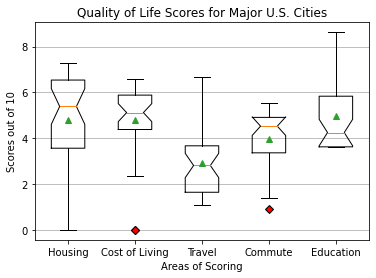

In [27]:
labels = ['Housing', 'Cost of Living', 'Travel', 'Commute',
          'Education']

areas= [housing, living, travel, commute, education]

fig, ax1 = plt.subplots()

diamond = dict(markerfacecolor='r', marker='D')

ax1.set_title('Quality of Life Scores for Major U.S. Cities')
ax1.yaxis.grid(True)
ax1.set_xlabel('Areas of Scoring')
ax1.set_ylabel('Scores out of 10')

ax1.boxplot(areas, labels=labels, notch=True, flierprops=diamond, showmeans=True)

plt.savefig("BoxPlot.png")
plt.show()

# Statistical Analysis of Scores

In [28]:
# Perform the ANOVA
stats.f_oneway(housing, living, travel, commute, education)

F_onewayResult(statistic=9.361008326196853, pvalue=7.036607698384077e-07)

In [29]:
# If the data is in a dataframe, we use pandas to give quartile calculations
hquartiles = housing.quantile([.25,.5,.75]).round(2)
hlowerq = hquartiles[0.25].round(2)
hupperq = hquartiles[0.75].round(2)
hiqr = hupperq-hlowerq.round(2)

print(f"The lower quartile of housing is: {hlowerq}")
print(f"The upper quartile of housing is: {hupperq}")
print(f"The interquartile range of housing is: {hiqr}")
print(f"The the median of housing is: {hquartiles[0.5]} ")

hlower_bound = hlowerq - (1.5*hiqr).round(2)
hupper_bound = hupperq + (1.5*hiqr).round(2)
print(f"Values below {hlower_bound} could be outliers.")
print(f"Values above {hupper_bound} could be outliers.")

The lower quartile of housing is: 3.56
The upper quartile of housing is: 6.54
The interquartile range of housing is: 2.98
The the median of housing is: 5.39 
Values below -0.9099999999999997 could be outliers.
Values above 11.01 could be outliers.


In [30]:
lquartiles = living.quantile([.25,.5,.75]).round(2)
llowerq = lquartiles[0.25].round(2)
lupperq = lquartiles[0.75].round(2)
liqr = lupperq-llowerq.round(2)

print(f"The lower quartile of cost of living is: {llowerq}")
print(f"The upper quartile of cost of living is: {lupperq}")
print(f"The interquartile range of cost of living is: {liqr}")
print(f"The the median of cost of living is: {hquartiles[0.5]} ")

llower_bound = llowerq - (1.5*liqr).round(2)
lupper_bound = lupperq + (1.5*liqr).round(2)
print(f"Values below {llower_bound} could be outliers.")
print(f"Values above {lupper_bound} could be outliers.")

The lower quartile of cost of living is: 4.38
The upper quartile of cost of living is: 5.88
The interquartile range of cost of living is: 1.5
The the median of cost of living is: 5.39 
Values below 2.13 could be outliers.
Values above 8.129999999999999 could be outliers.


In [31]:
tquartiles = travel.quantile([.25,.5,.75]).round(2)
tlowerq = tquartiles[0.25].round(2)
tupperq = hquartiles[0.75].round(2)
tiqr = tupperq-tlowerq.round(2)

print(f"The lower quartile of travel connectivity is: {tlowerq}")
print(f"The upper quartile of travel connectivity is: {tupperq}")
print(f"The interquartile range of travel connectivity is: {tiqr}")
print(f"The the median of travel connectivity is: {tquartiles[0.5]} ")

tlower_bound = tlowerq - (1.5*tiqr).round(2)
tupper_bound = tupperq + (1.5*tiqr).round(2)
print(f"Values below {tlower_bound} could be outliers.")
print(f"Values above {tupper_bound} could be outliers.")

The lower quartile of travel connectivity is: 1.64
The upper quartile of travel connectivity is: 6.54
The interquartile range of travel connectivity is: 4.9
The the median of travel connectivity is: 2.81 
Values below -5.71 could be outliers.
Values above 13.89 could be outliers.


In [32]:
cquartiles = commute.quantile([.25,.5,.75]).round(2)
clowerq = cquartiles[0.25].round(2)
cupperq = cquartiles[0.75].round(2)
ciqr = cupperq-clowerq.round(2)

print(f"The lower quartile of commute is: {clowerq}")
print(f"The upper quartile of commute is: {cupperq}")
print(f"The interquartile range of commute is: {ciqr}")
print(f"The the median of commute is: {cquartiles[0.5]} ")

clower_bound = clowerq - (1.5*ciqr).round(2)
cupper_bound = cupperq + (1.5*ciqr).round(2)
print(f"Values below {clower_bound} could be outliers.")
print(f"Values above {cupper_bound} could be outliers.")

The lower quartile of commute is: 3.36
The upper quartile of commute is: 4.91
The interquartile range of commute is: 1.5500000000000003
The the median of commute is: 4.53 
Values below 1.0299999999999998 could be outliers.
Values above 7.24 could be outliers.


In [33]:
equartiles = education.quantile([.25,.5,.75]).round(2)
elowerq = equartiles[0.25].round(2)
eupperq = equartiles[0.75].round(2)
eiqr = eupperq-elowerq.round(2)

print(f"The lower quartile of housing is: {elowerq}")
print(f"The upper quartile of housing is: {eupperq}")
print(f"The interquartile range of housing is: {eiqr}")
print(f"The the median of housing is: {equartiles[0.5]} ")

elower_bound = elowerq - (1.5*eiqr).round(2)
eupper_bound = eupperq + (1.5*eiqr).round(2)
print(f"Values below {elower_bound} could be outliers.")
print(f"Values above {eupper_bound} could be outliers.")

The lower quartile of housing is: 3.62
The upper quartile of housing is: 5.83
The interquartile range of housing is: 2.21
The the median of housing is: 4.25 
Values below 0.30000000000000027 could be outliers.
Values above 9.15 could be outliers.


# Scatter Plot Latitude vs. Housing Scores

R squared: 0.011315613918332948


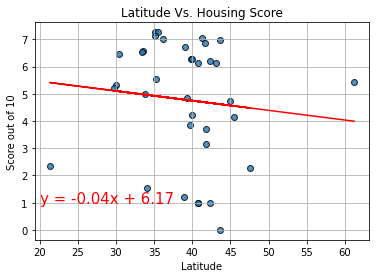

In [34]:
from scipy.stats import linregress
import seaborn as sns

#Store as x and y values
x_values = lat
y_values = housing

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Score out of 10')
plt.title('Latitude Vs. Housing Score')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsHousing.png")

# Show plot
plt.show()

# Scatter Plot Longitude vs. Housing Scores

R squared: 0.025080679976480447


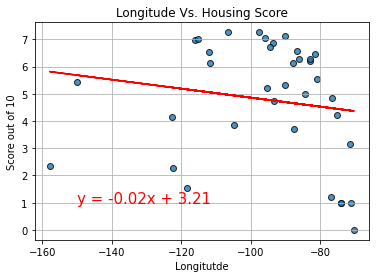

In [35]:
from scipy.stats import linregress
import seaborn as sns

#Store as x and y values
x_values = lon
y_values = housing

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-150,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Longitutde')
plt.ylabel('Score out of 10')
plt.title('Longitude Vs. Housing Score')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LonVsHousing.png")

# Show plot
plt.show()

# Scatter Plot Latitude vs. Cost of Living Scores

R squared: 0.04349257799224935


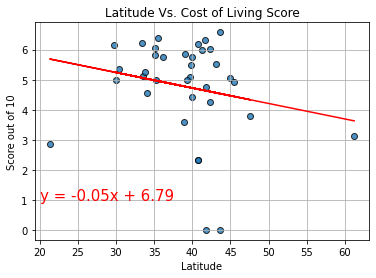

In [36]:
#Store as x and y values
x_values = lat
y_values = living

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Score out of 10')
plt.title('Latitude Vs. Cost of Living Score')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsLiving.png")

# Show plot
plt.show()

# Scatter Plot Longitude vs. Cost of Living Scores

R squared: 0.027018836279562284


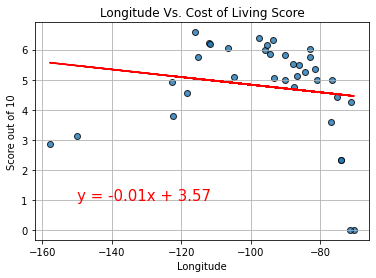

In [37]:
#Store as x and y values
x_values = lon
y_values = living

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-150,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Longitude')
plt.ylabel('Score out of 10')
plt.title('Longitude Vs. Cost of Living Score')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LonVsLiving.png")

# Show plot
plt.show()

# Scatter Plot Latitude vs. Travel Connectivity Scores

R squared: 0.00043810006006456196


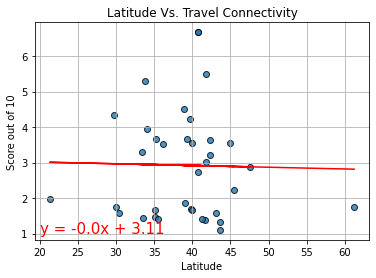

In [38]:
#Store as x and y values
x_values = lat
y_values = travel

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Score out of 10')
plt.title('Latitude Vs. Travel Connectivity')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsTravel.png")

# Show plot
plt.show()

# Scatter Plot Longitude vs. Travel Connectivity Scores

R squared: 0.07475069754624185


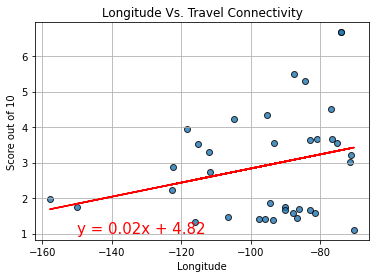

In [39]:
#Store as x and y values
x_values = lon
y_values = travel

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-150,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Longitude')
plt.ylabel('Score out of 10')
plt.title('Longitude Vs. Travel Connectivity')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LonVsTravel.png")

# Show plot
plt.show()

# Scatter Plot Latitude vs. Commute Scores

R squared: 0.016728887798291212


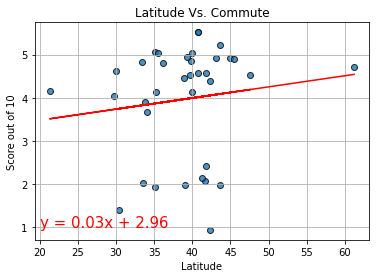

In [40]:
#Store as x and y values
x_values = lat
y_values = commute

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Score out of 10')
plt.title('Latitude Vs. Commute')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsCommute.png")

# Show plot
plt.show()

# Scatter Plot Longitude vs. Commute Scores

R squared: 0.0515596503891089


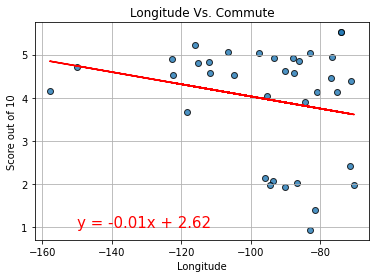

In [41]:
#Store as x and y values
x_values = lon
y_values = commute

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-150,1),fontsize=15,color="red")

# Label plot
plt.xlabel('Longitude')
plt.ylabel('Score out of 10')
plt.title('Longitude Vs. Commute')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LonVsCommute.png")

# Show plot
plt.show()

# Scatter Plot Latitude vs. Population Size

R squared: 0.006204019891388824


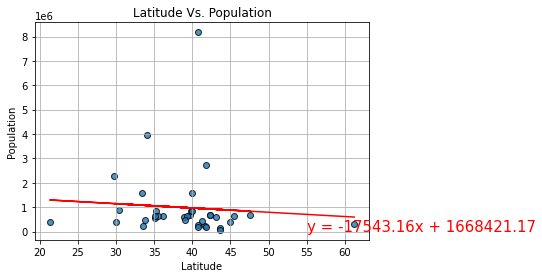

In [42]:
#Store as x and y values
x_values = lat
y_values = pop

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(55,6),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Population')
plt.title('Latitude Vs. Population')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsPopulation.png")

# Show plot
plt.show()

# Scatter Plot Longitude vs. Population Size

R squared: 0.014273328561601913


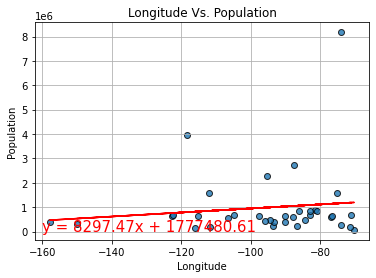

In [43]:
#Store as x and y values
x_values = lon
y_values = pop

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-160,6),fontsize=15,color="red")

# Label plot
plt.xlabel('Longitude')
plt.ylabel('Population')
plt.title('Longitude Vs. Population')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LonVsPopulation.png")

# Show plot
plt.show()

# Scatter Plot Latitude vs. Education Scores

R squared: 0.003885188845251327


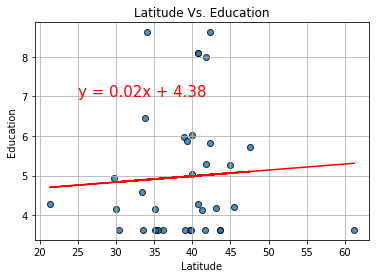

In [44]:
#Store as x and y values
x_values = lat
y_values = education

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(25,7),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Education')
plt.title('Latitude Vs. Education')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsEducation.png")

# Show plot
plt.show()

# Scatter Plot Longitude vs. Education Scores

R squared: 0.08978809631708037


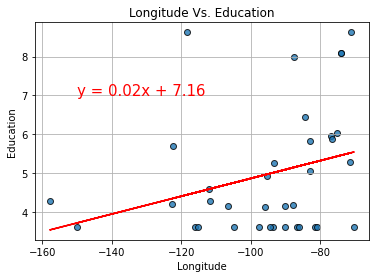

In [45]:
#Store as x and y values
x_values = lon
y_values = education

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-150,7),fontsize=15,color="red")

# Label plot
plt.xlabel('Longitude')
plt.ylabel('Education')
plt.title('Longitude Vs. Education')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LonVsEducation.png")

# Show plot
plt.show()

# Scatter Plot Latitude vs. Total Scores

R squared: 0.00803642656949017


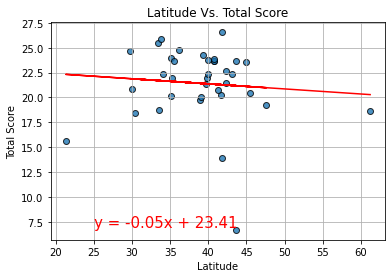

In [46]:
#Store as x and y values
x_values = lat
y_values = total

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(25,7),fontsize=15,color="red")

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Total Score')
plt.title('Latitude Vs. Total Score')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LatVsTotal.png")

# Show plot
plt.show()

# Scatter Plot Longitude vs. Total Scores

R squared: 1.043241371603495e-05


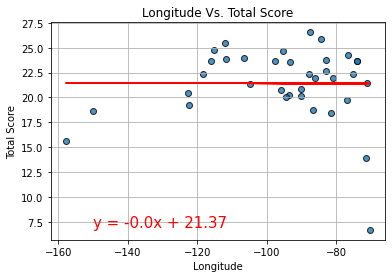

In [47]:
#Store as x and y values
x_values = lon
y_values = total

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-150,7),fontsize=15,color="red")

# Label plot
plt.xlabel('Longitude')
plt.ylabel('Total Score')
plt.title('Longitude Vs. Total Score')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("LonVsTotal.png")

# Show plot
plt.show()

# Scatter Plot Population vs. Total Scores

R squared: 0.07559744668920104


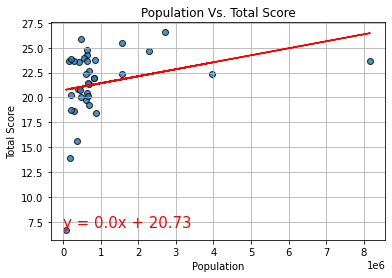

In [48]:
#Store as x and y values
x_values = pop
y_values = total

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values, alpha=0.8, edgecolor="black", linewidths=1)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-150,7),fontsize=15,color="red")

# Label plot
plt.xlabel('Population')
plt.ylabel('Total Score')
plt.title('Population Vs. Total Score')
plt.grid(True)
sns.set

# Print r square value
print(f"R squared: {rvalue**2}")

plt.savefig("PopVsTotal.png")

# Show plot
plt.show()

# Color Plot City Location vs. Housing Scores

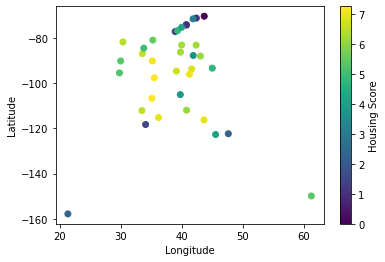

In [49]:
plt.scatter(lat,lon,c=housing)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Housing Score")

plt.savefig("Housingcolorscore.png")
plt.show()

# Color Plot City Location vs. Living Scores

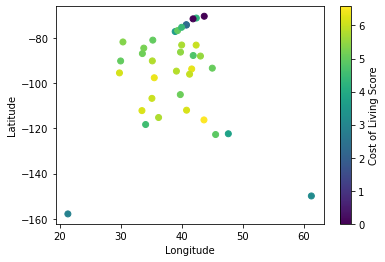

In [50]:
plt.scatter(lat,lon,c=living)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Cost of Living Score")
plt.savefig("costcolorscore.png")
plt.show()

# Color Plot City Location vs. Travel Connectivity Scores

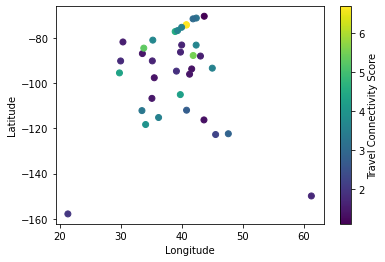

In [51]:
plt.scatter(lat,lon,c=travel)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Travel Connectivity Score")
plt.savefig("travelcolorscore.png")
plt.show()

# Color Plot City Location vs. Commute Scores

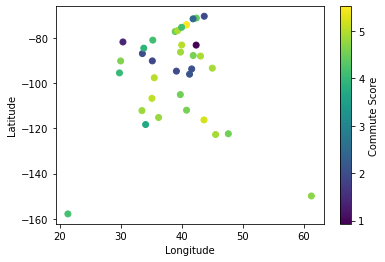

In [52]:
plt.scatter(lat,lon,c=commute)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Commute Score")
plt.savefig("commutecolorscore.png")
plt.show()

# Color Plot City Location vs. Education Scores

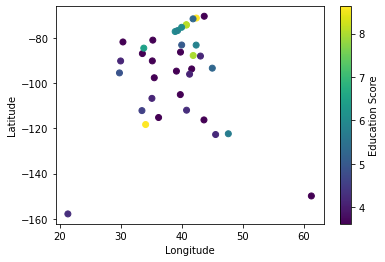

In [53]:
plt.scatter(lat,lon,c=education)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Education Score")


# Show plot
plt.savefig("educationcolorscore.png")
plt.show()

# Color Plot City Location vs. Population Density

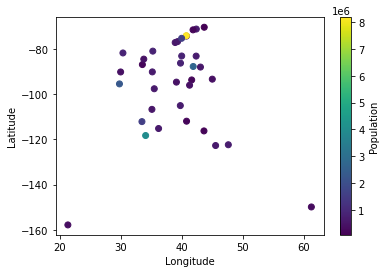

In [54]:
plt.scatter(lat,lon,c=pop)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Population")


# Show plot
plt.savefig("populationdensity.png")
plt.show()

# Color Plot City Location vs. Total Scores

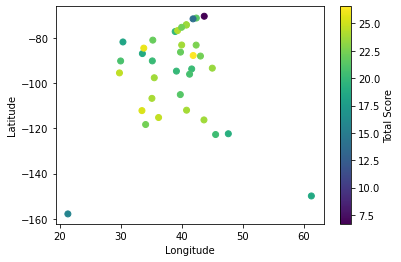

In [55]:
plt.scatter(lat,lon,c=total)
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Total Score")


# Show plot
plt.savefig("TotalQualityofLifeColorScore.png")
plt.show()

# Stacked Bar Graph of Total City Scores

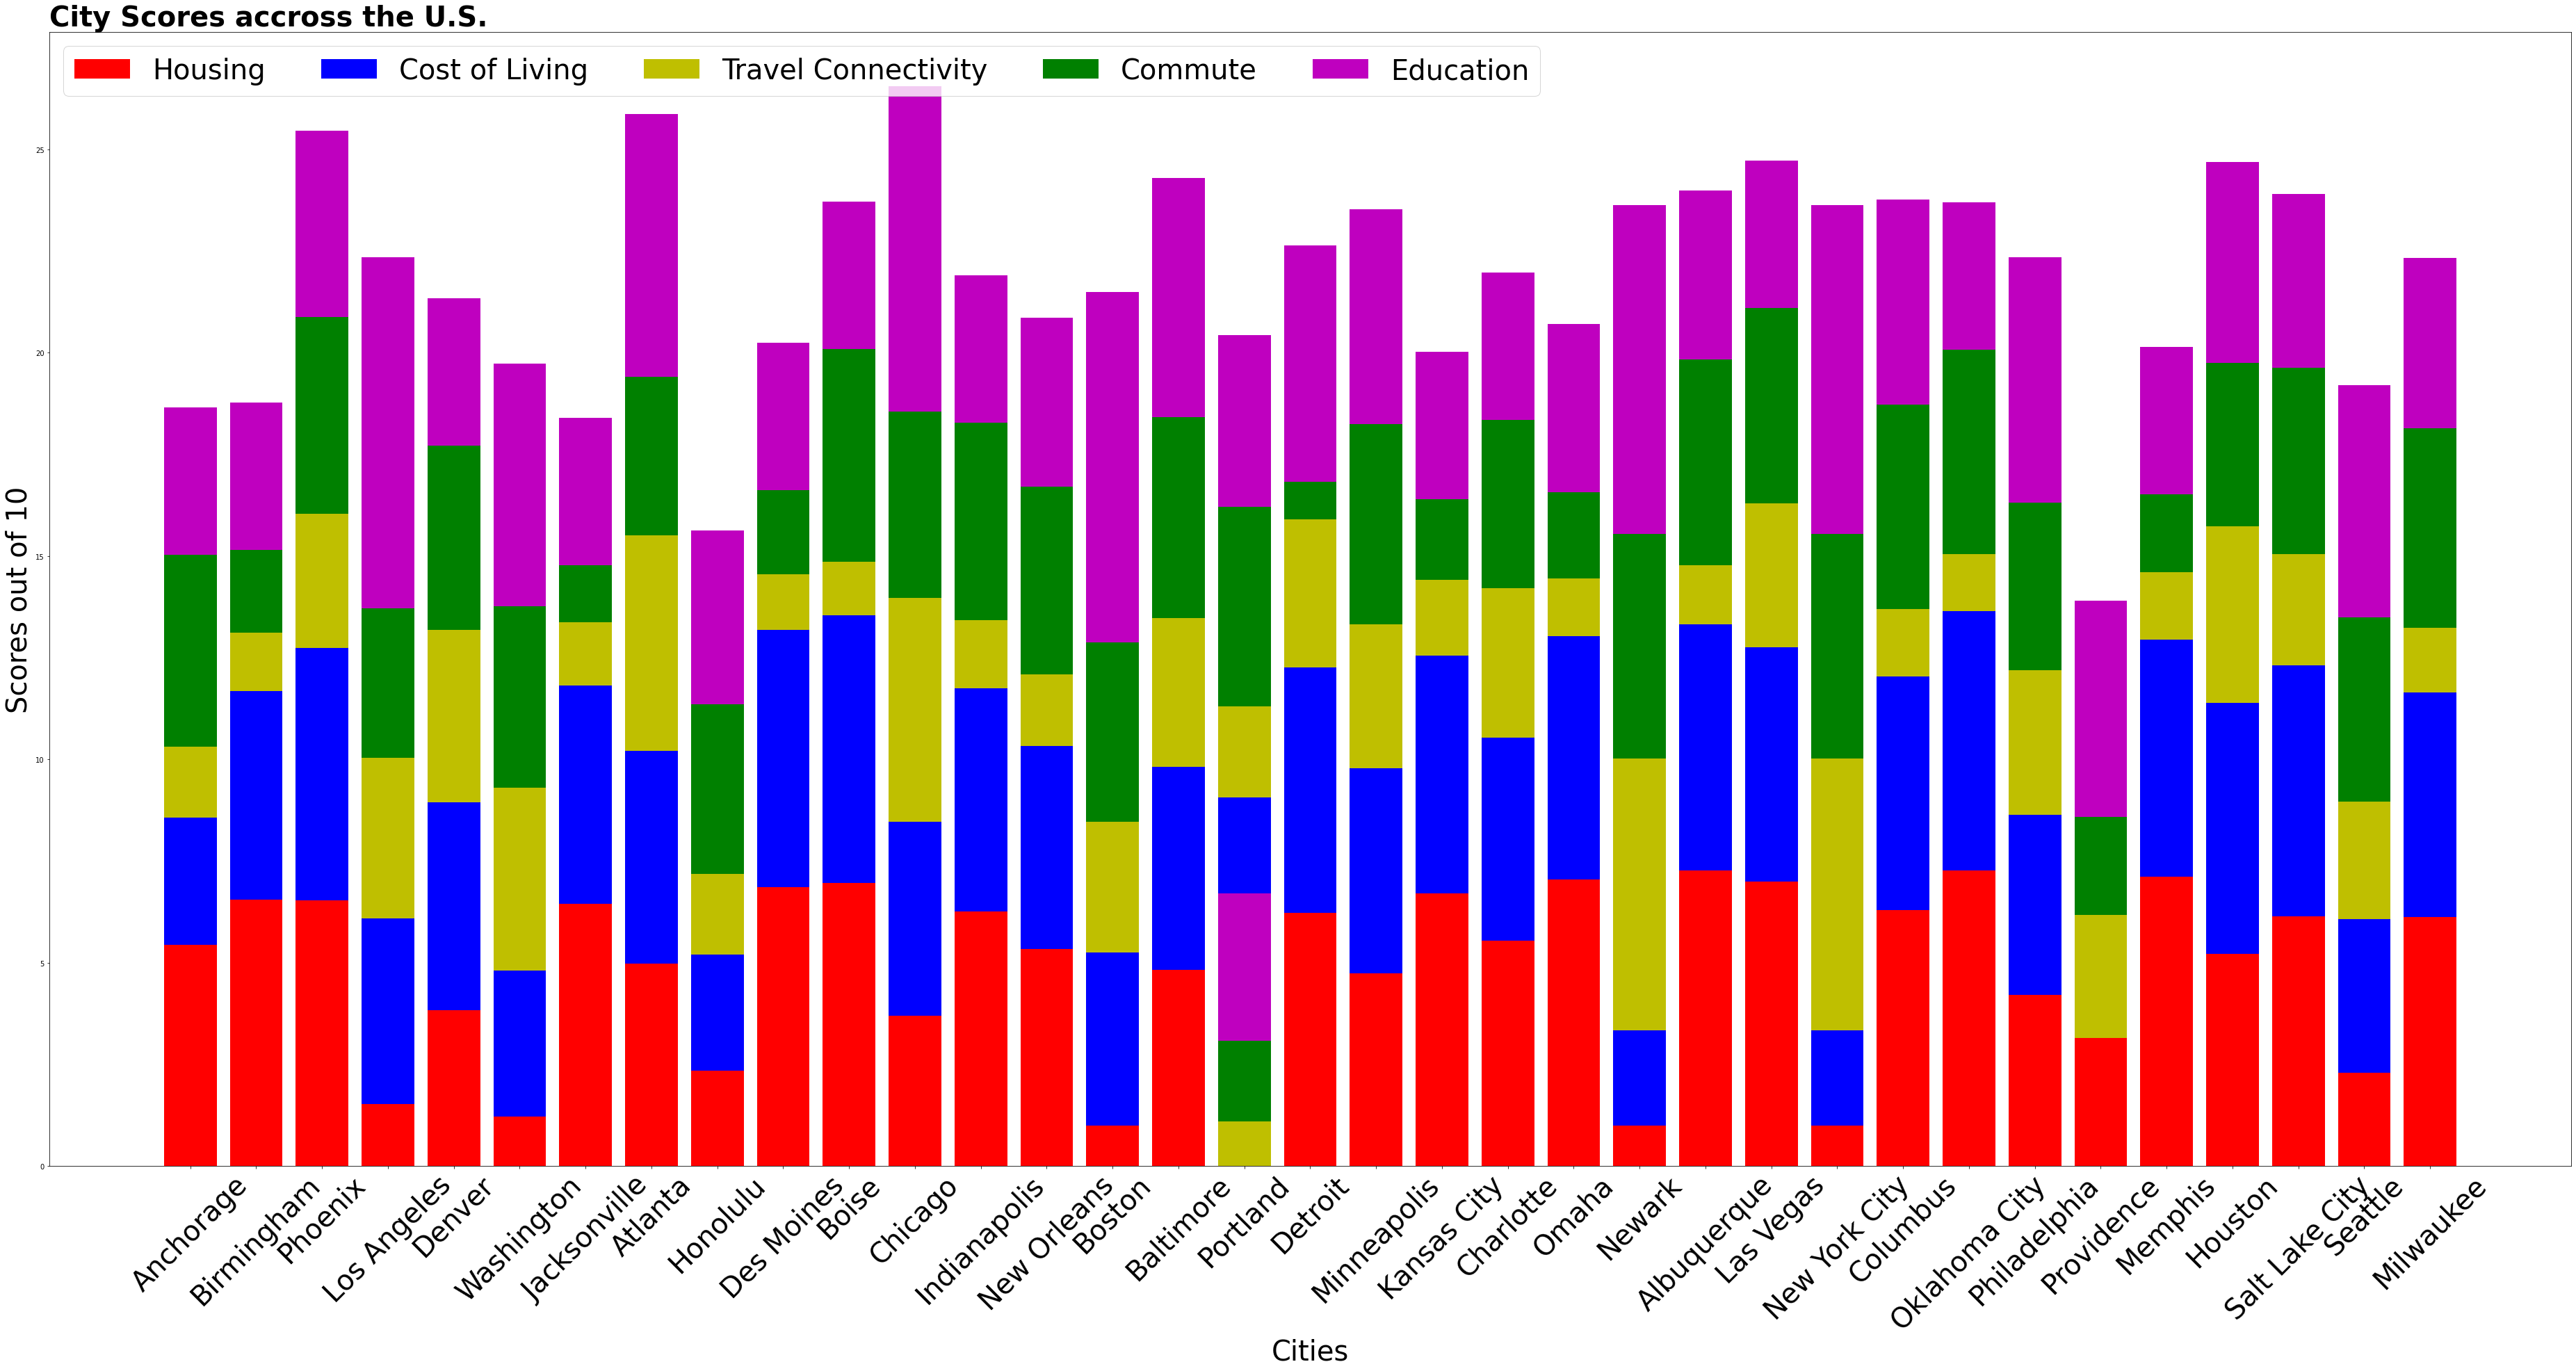

In [56]:
# importing package
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, figsize=(65, 30))
# create data
x = cities
y1 = np.array(housing)
y2 = np.array(living)
y3 = np.array(travel)
y4 = np.array(commute)
y5 = np.array(education)
  
# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='y')
plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.bar(x, y5, bottom=y1+y2+y3+y4, color='m')
plt.xlabel("Cities", fontsize=40)
plt.ylabel("Scores out of 10", fontsize=40)
plt.legend(["Housing", "Cost of Living", "Travel Connectivity", "Commute", "Education"],loc='upper left', ncol = 5, fontsize=40)
plt.title("City Scores accross the U.S.", loc ='left', fontsize=40, weight='bold')
fig.align_labels()
plt.xticks(fontsize=40,rotation = 45) # Rotates X-Axis Ticks by 45-degrees

plt.savefig("CityScores.png")
plt.show()


# Bar Graph of All City Scores

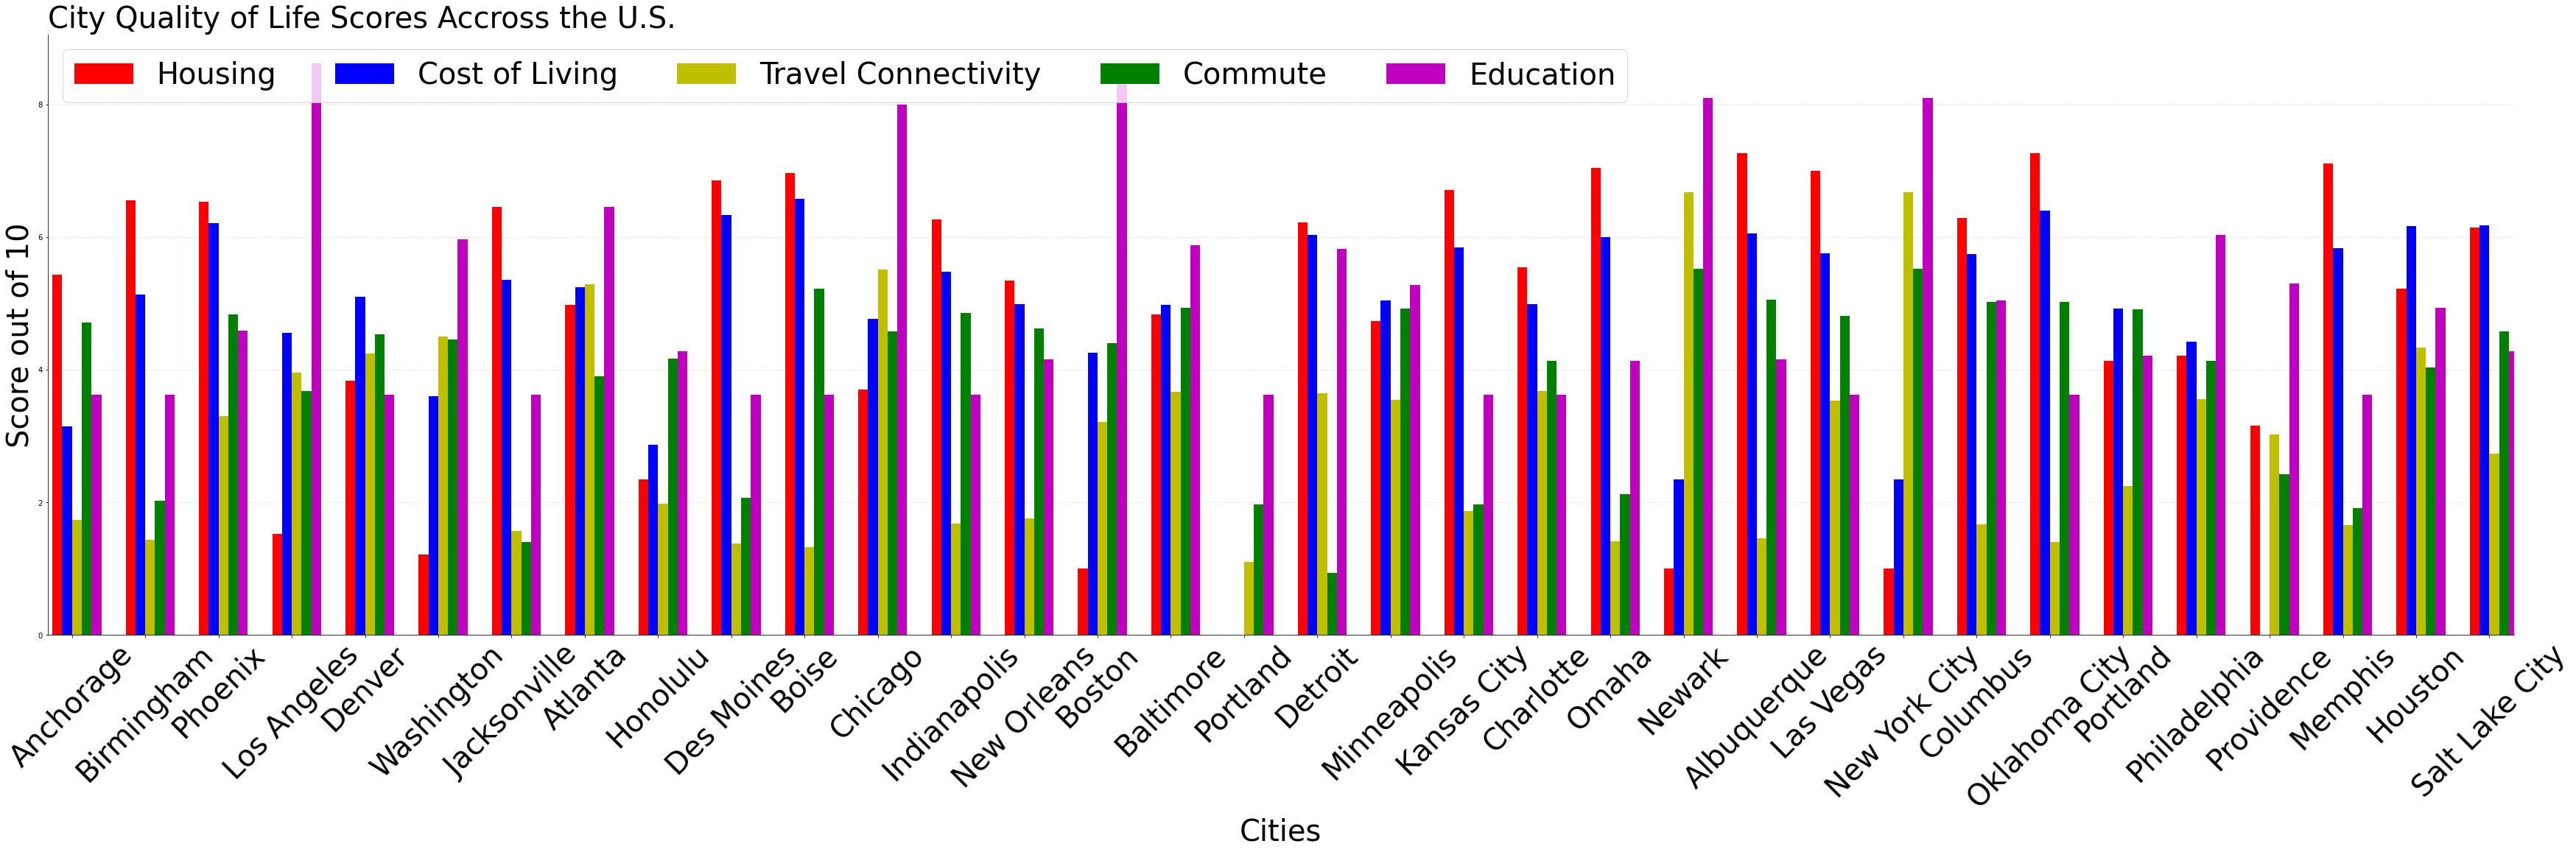

In [57]:
# define figure
fig, ax = plt.subplots(1, figsize=(60, 15))

# numerical x
x = np.arange(0, len(cities))*1.5

# plot bars
plt.bar(x - 0.3, housing, width = 0.2, color = 'r')
plt.bar(x - 0.1, living, width = 0.2, color = 'b')
plt.bar(x + 0.1, travel, width = 0.2, color = 'y')
plt.bar(x + 0.3, commute, width = 0.2, color = 'g')
plt.bar(x + 0.5, education, width = 0.2, color = 'm')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# x y details
plt.ylabel('Score out of 10', fontsize=40)
plt.xlabel("Cities", fontsize=40)
plt.xticks(x, cities, rotation = 45, fontsize=40)
plt.xlim(-0.5, 50)

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.2)

# title and legend
plt.title('City Quality of Life Scores Accross the U.S.', loc ='left', fontsize= 40)
plt.legend(['Housing', 'Cost of Living', 'Travel Connectivity', 'Commute', 'Education'], loc='upper left', ncol = 5, fontsize= 40)
plt.savefig("CityScores2.png")
fig.align_labels()

fig.align_labels()
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees

plt.show()


In [58]:
#Create new df showing top 5 cities and bottom 5 cities in each score collumn

#Sort by collumn and keep only 5

sorted_top_housing = qol_df.sort_values(by = 'Housing', ascending = False, ignore_index=True)
top_5_housing=sorted_top_housing.head(5)
top_5_housing.to_csv("Top5inHousing.csv")
top_5_housing

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Albuquerque,NM,US,559121,35.08449,-106.65114,7.2620,6.059,1.4555,5.05575,4.1520,23.98425
1,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245,23.70575
2,Memphis,TN,US,655770,35.14953,-90.04898,7.1145,5.829,1.6615,1.91750,3.6245,20.14700
3,Omaha,NE,US,443885,41.25626,-95.94043,7.0405,5.994,1.4165,2.12775,4.1280,20.70675
4,Las Vegas,NV,US,623747,36.17497,-115.13722,7.0010,5.759,3.5285,4.80750,3.6245,24.72050


In [59]:
sorted_bottom_housing = qol_df.sort_values(by = 'Housing', ascending = True, ignore_index=True)
bottom_5_housing=sorted_bottom_housing.head(5)
bottom_5_housing.to_csv("Bottom5inHousing.csv")
bottom_5_housing

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Portland,ME,US,66881,43.65737,-70.2589,0.0000,0.000,1.102,1.97025,3.6245,6.69675
1,Boston,MA,US,667137,42.35843,-71.05977,1.0000,4.259,3.215,4.39625,8.6245,21.49475
2,Newark,NJ,US,281944,40.73566,-74.17237,1.0000,2.342,6.675,5.51925,8.0935,23.62975
3,New York City,NY,US,8175133,40.71427,-74.00597,1.0000,2.342,6.675,5.51925,8.0935,23.62975
4,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,4.505,4.45700,5.9685,19.73600


In [60]:
sorted_top_living = qol_df.sort_values(by = 'Cost of Living', ascending = False, ignore_index=True)
top_5_living=sorted_top_living.head(5)
top_5_living.to_csv("Top5inCostofLiving.csv")
top_5_living

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Boise,ID,US,145987,43.6135,-116.20345,6.9635,6.578,1.3235,5.22500,3.6245,23.71450
1,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245,23.70575
2,Des Moines,IA,US,210330,41.60054,-93.60911,6.8510,6.327,1.3790,2.07225,3.6245,20.25375
3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.5330,6.208,3.3025,4.82850,4.5910,25.46300
4,Salt Lake City,UT,US,192672,40.76078,-111.89105,6.1410,6.172,2.7370,4.57400,4.2805,23.90450


In [61]:
sorted_bottom_living = qol_df.sort_values(by = 'Cost of Living', ascending = True, ignore_index=True)
bottom_5_living=sorted_bottom_living.head(5)
bottom_5_living.to_csv("Bottom5inCostofLiving.csv")
bottom_5_living

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Providence,RI,US,179207,41.82399,-71.41283,3.1530,0.000,3.0185,2.42200,5.3015,13.89500
1,Portland,ME,US,66881,43.65737,-70.2589,0.0000,0.000,1.1020,1.97025,3.6245,6.69675
2,Newark,NJ,US,281944,40.73566,-74.17237,1.0000,2.342,6.6750,5.51925,8.0935,23.62975
3,New York City,NY,US,8175133,40.71427,-74.00597,1.0000,2.342,6.6750,5.51925,8.0935,23.62975
4,Honolulu,HI,US,371657,21.30694,-157.85833,2.3415,2.867,1.9830,4.16175,4.2805,15.63375


In [62]:
sorted_top_travel = qol_df.sort_values(by = 'Travel Connectivity', ascending = False, ignore_index=True)
top_5_travel=sorted_top_travel.head(5)
top_5_travel.to_csv("Top5inTravel.csv")
top_5_travel

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Newark,NJ,US,281944,40.73566,-74.17237,1.0000,2.342,6.6750,5.51925,8.0935,23.62975
1,New York City,NY,US,8175133,40.71427,-74.00597,1.0000,2.342,6.6750,5.51925,8.0935,23.62975
2,Chicago,IL,US,2720546,41.85003,-87.65005,3.7020,4.766,5.5075,4.57975,7.9990,26.55425
3,Atlanta,GA,US,463878,33.749,-84.38798,4.9755,5.241,5.2915,3.89775,6.4570,25.86275
4,Washington,DC,US,601723,38.89511,-77.03637,1.2105,3.595,4.5050,4.45700,5.9685,19.73600


In [63]:
sorted_bottom_travel = qol_df.sort_values(by = 'Travel Connectivity', ascending = True, ignore_index=True)
bottom_5_travel=sorted_bottom_travel.head(5)
bottom_5_travel.to_csv("Bottom5inTravel.csv")
bottom_5_travel

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Portland,ME,US,66881,43.65737,-70.2589,0.0000,0.000,1.1020,1.97025,3.6245,6.69675
1,Boise,ID,US,145987,43.6135,-116.20345,6.9635,6.578,1.3235,5.22500,3.6245,23.71450
2,Des Moines,IA,US,210330,41.60054,-93.60911,6.8510,6.327,1.3790,2.07225,3.6245,20.25375
3,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245,23.70575
4,Omaha,NE,US,443885,41.25626,-95.94043,7.0405,5.994,1.4165,2.12775,4.1280,20.70675


In [64]:
sorted_top_commute = qol_df.sort_values(by = 'Commute', ascending = False, ignore_index=True)
top_5_commute=sorted_top_commute.head(5)
top_5_commute.to_csv("Top5inCommute.csv")
top_5_commute

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,New York City,NY,US,8175133,40.71427,-74.00597,1.0000,2.342,6.6750,5.51925,8.0935,23.62975
1,Newark,NJ,US,281944,40.73566,-74.17237,1.0000,2.342,6.6750,5.51925,8.0935,23.62975
2,Boise,ID,US,145987,43.6135,-116.20345,6.9635,6.578,1.3235,5.22500,3.6245,23.71450
3,Albuquerque,NM,US,559121,35.08449,-106.65114,7.2620,6.059,1.4555,5.05575,4.1520,23.98425
4,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245,23.70575


In [65]:
sorted_bottom_commute = qol_df.sort_values(by = 'Commute', ascending = True, ignore_index=True)
bottom_5_commute=sorted_bottom_commute.head(5)
bottom_5_commute.to_csv("Bottom5inCommute.csv")
bottom_5_commute

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Detroit,MI,US,677116,42.33143,-83.04575,6.2230,6.032,3.6405,0.93300,5.8185,22.64700
1,Jacksonville,FL,US,868031,30.33218,-81.65565,6.4500,5.359,1.5675,1.40575,3.6245,18.40675
2,Memphis,TN,US,655770,35.14953,-90.04898,7.1145,5.829,1.6615,1.91750,3.6245,20.14700
3,Portland,ME,US,66881,43.65737,-70.2589,0.0000,0.000,1.1020,1.97025,3.6245,6.69675
4,Kansas City,MO,US,475378,39.09973,-94.57857,6.7075,5.844,1.8690,1.97250,3.6245,20.01750


In [66]:
sorted_top_education = qol_df.sort_values(by = 'Education', ascending = False, ignore_index=True)
top_5_education=sorted_top_education.head(5)
top_5_education.to_csv("Top5inEducation.csv")
top_5_education

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Los Angeles,CA,US,3971883,34.05223,-118.24368,1.5275,4.556,3.9585,3.67700,8.6245,22.34350
1,Boston,MA,US,667137,42.35843,-71.05977,1.0000,4.259,3.2150,4.39625,8.6245,21.49475
2,New York City,NY,US,8175133,40.71427,-74.00597,1.0000,2.342,6.6750,5.51925,8.0935,23.62975
3,Newark,NJ,US,281944,40.73566,-74.17237,1.0000,2.342,6.6750,5.51925,8.0935,23.62975
4,Chicago,IL,US,2720546,41.85003,-87.65005,3.7020,4.766,5.5075,4.57975,7.9990,26.55425


In [67]:
sorted_bottom_education = qol_df.sort_values(by = 'Education', ascending = True, ignore_index=True)
bottom_5_education=sorted_bottom_education.head(5)
bottom_5_education.to_csv("Bottom5inEducation.csv")
bottom_5_education

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.7380,4.71525,3.6245,18.65225
1,Birmingham,AL,US,212461,33.52066,-86.80249,6.5555,5.133,1.4355,2.02075,3.6245,18.76925
2,Memphis,TN,US,655770,35.14953,-90.04898,7.1145,5.829,1.6615,1.91750,3.6245,20.14700
3,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245,23.70575
4,Denver,CO,US,682545,39.73915,-104.9847,3.8375,5.102,4.2430,4.53000,3.6245,21.33700


# Statistical Graphs of All Relational Data

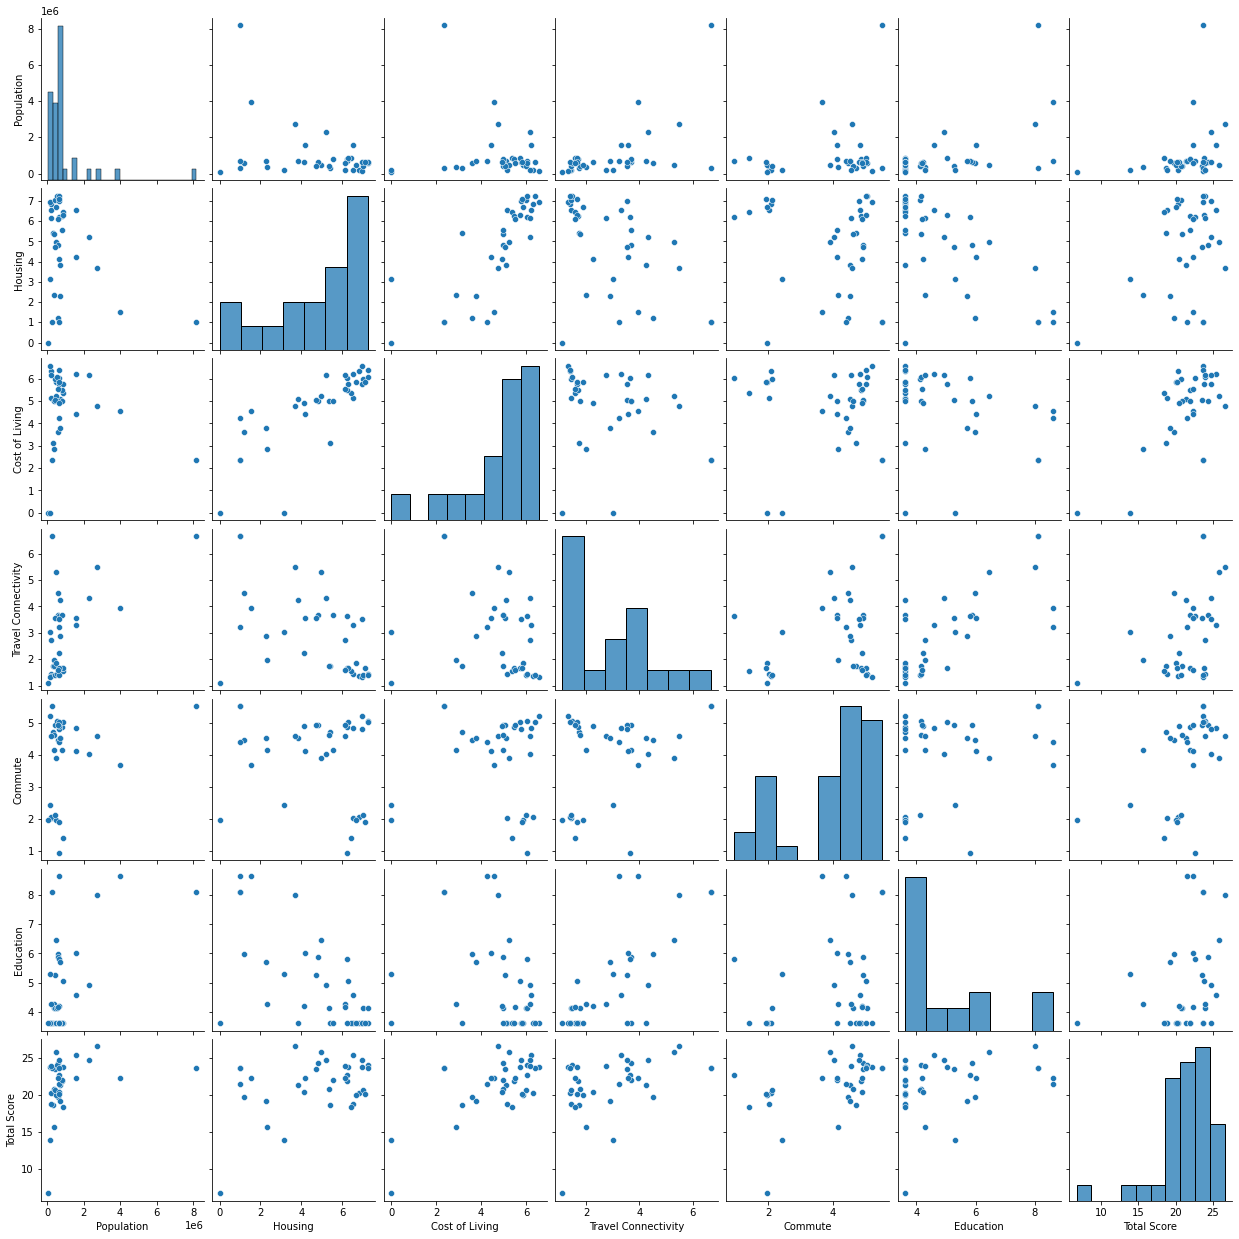

<Figure size 800x800 with 0 Axes>

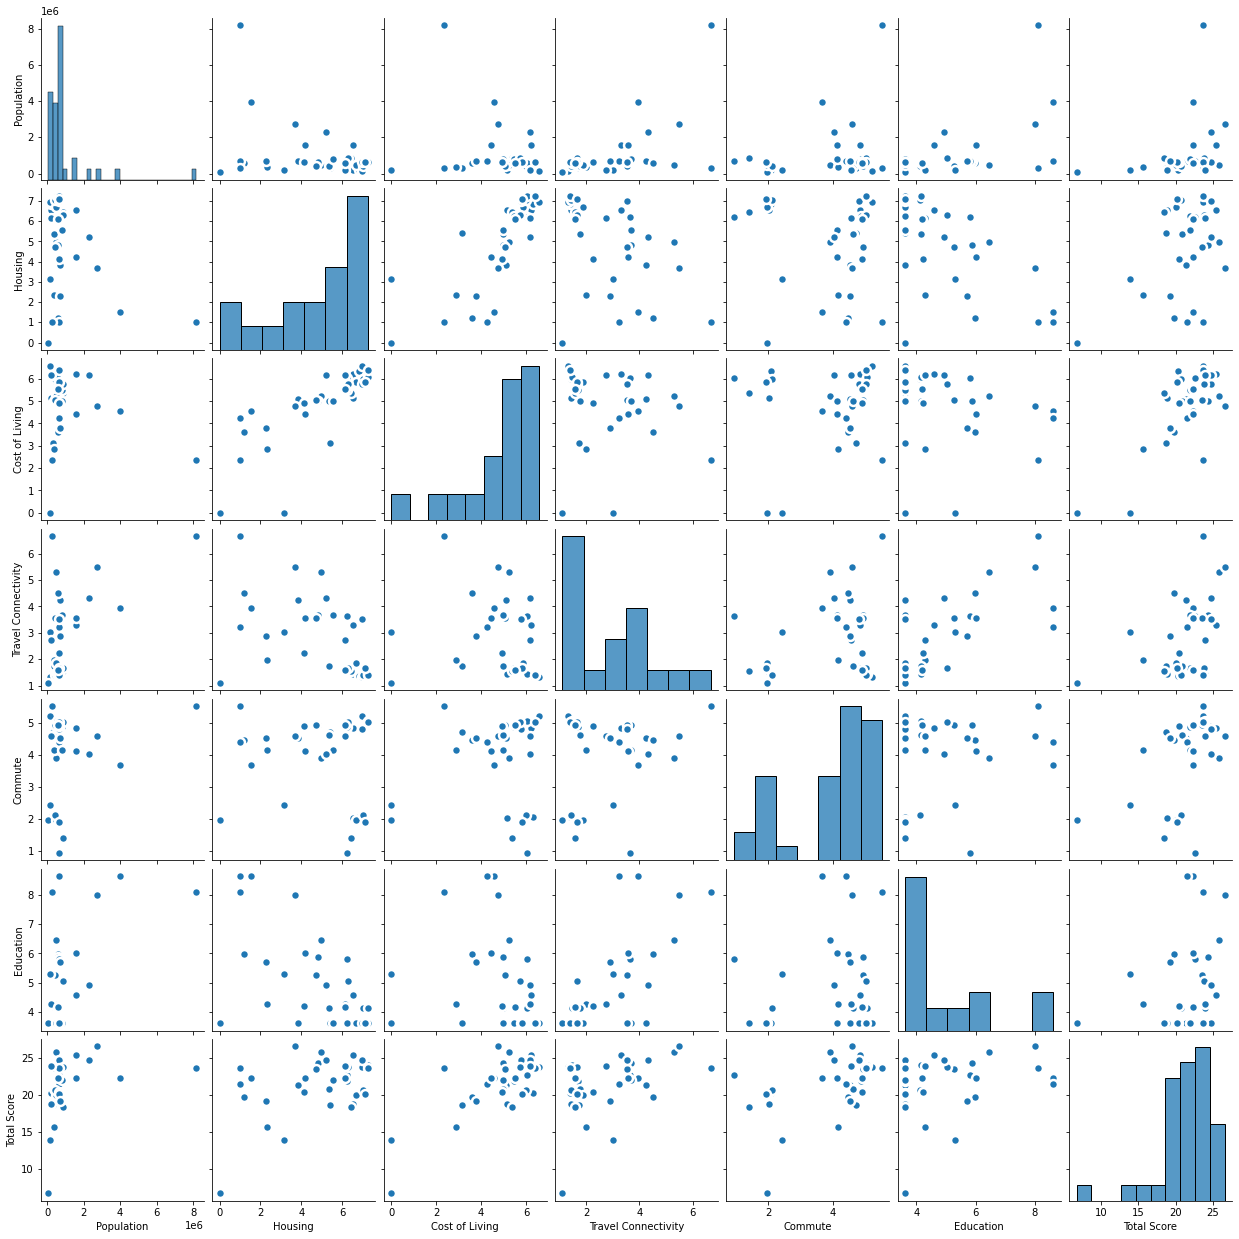

In [68]:
import seaborn as sns

sns.pairplot(qol_df)

# Plot
plt.figure(figsize=(10,10), dpi= 80)
sns.pairplot(qol_df, kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.savefig("Pairplot.png")
plt.show()

# Correlation Coefficient Correlation Graphs of All Relational Data

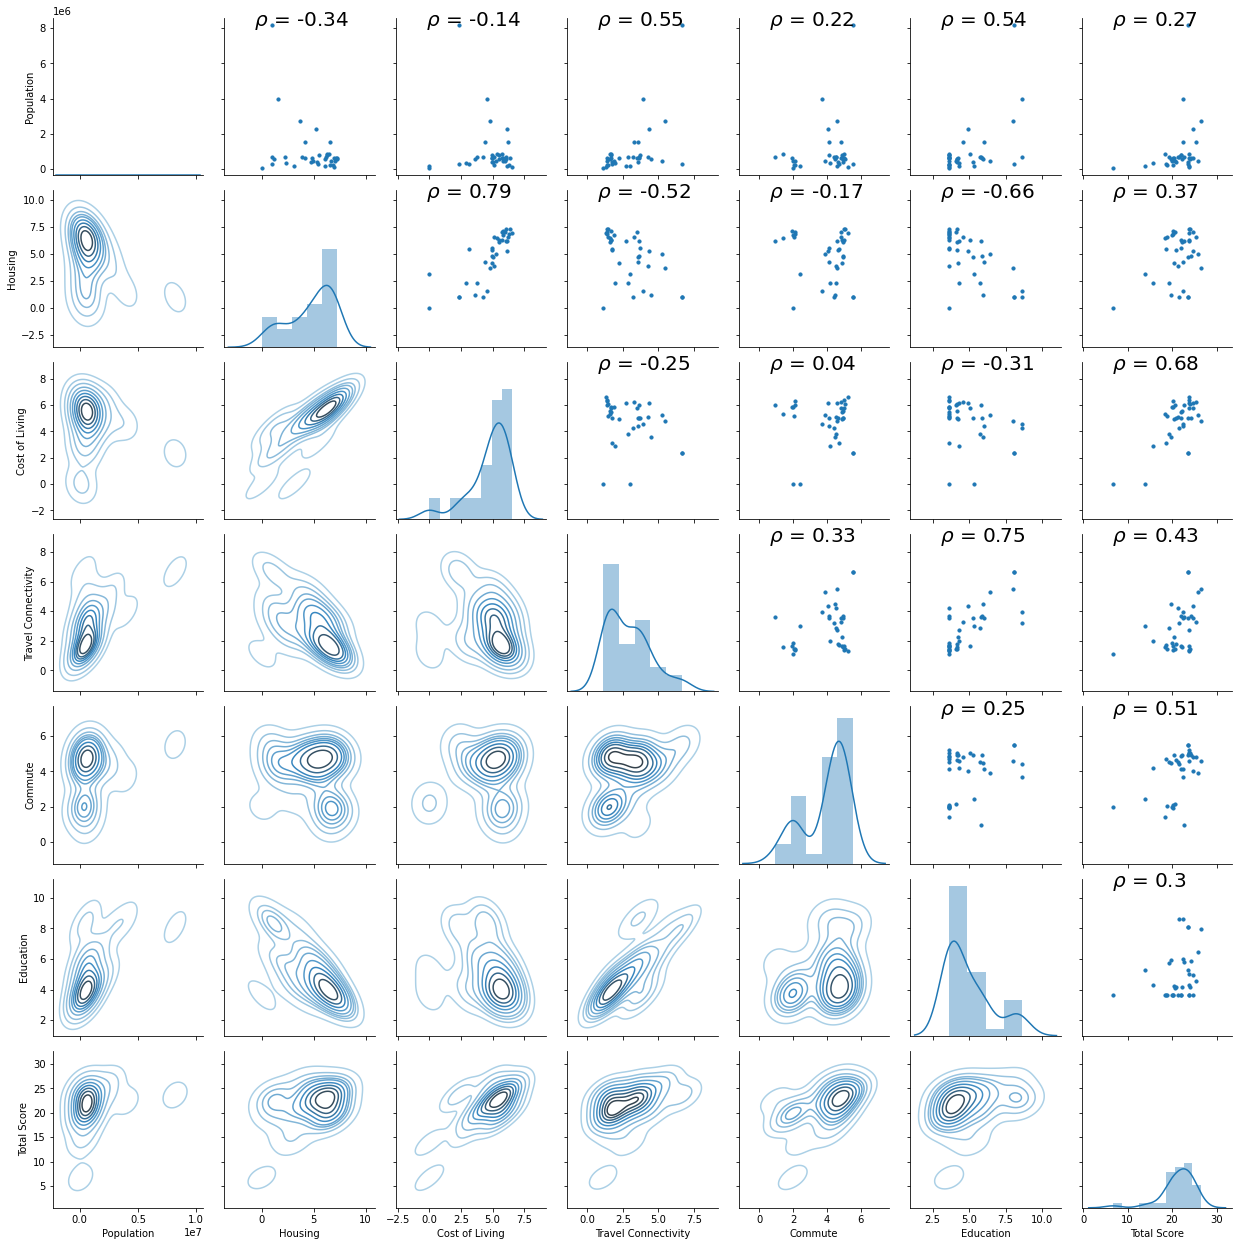

In [69]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    

# Map the plots to the locations
g = sns.PairGrid(qol_df, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_upper(corr)
g.map_diag(sns.distplot, kde=True)
g.map_lower(sns.kdeplot, cmap="Blues_d")
plt.savefig("PearsonRGrid.png")

# Correlogram of Quality of Life Scores

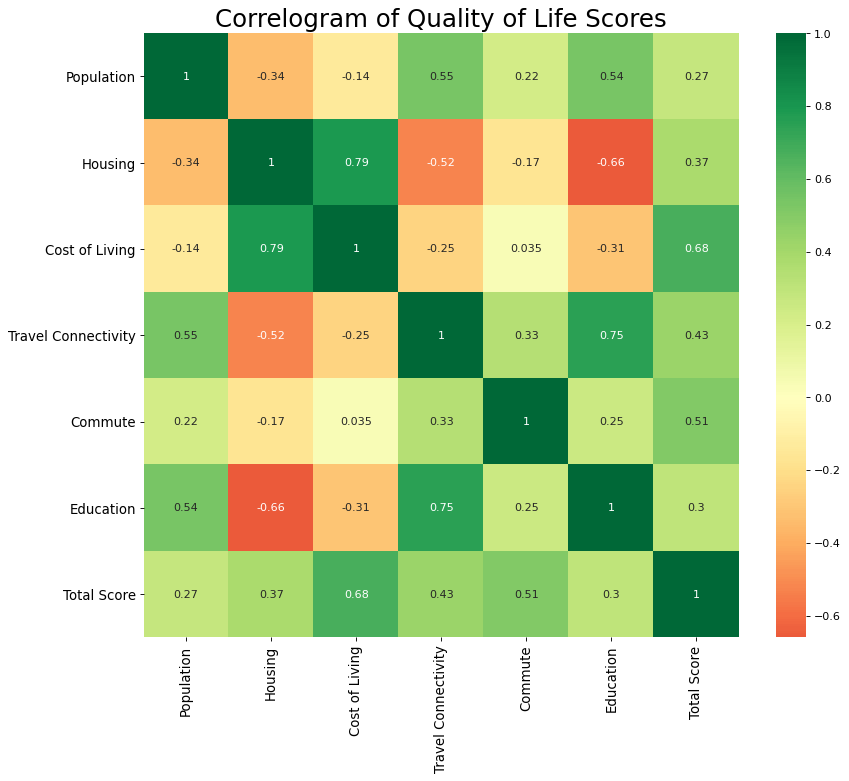

In [70]:
# Plot
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(qol_df.corr(), xticklabels=qol_df.corr().columns, yticklabels=qol_df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of Quality of Life Scores', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("CorrelogramScores.png")
plt.show()

In [71]:
#Sort Total Scores to find top 5 and bottom 5 rated cities

sorted_top_total = qol_df.sort_values(by = 'Total Score', ascending = False, ignore_index=True)
top_5_total=sorted_top_living.head(5)
top_5_total.to_csv("Top5CitiesTotalScore.csv")
top_5_total

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Boise,ID,US,145987,43.6135,-116.20345,6.9635,6.578,1.3235,5.22500,3.6245,23.71450
1,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245,23.70575
2,Des Moines,IA,US,210330,41.60054,-93.60911,6.8510,6.327,1.3790,2.07225,3.6245,20.25375
3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.5330,6.208,3.3025,4.82850,4.5910,25.46300
4,Salt Lake City,UT,US,192672,40.76078,-111.89105,6.1410,6.172,2.7370,4.57400,4.2805,23.90450


In [72]:
sorted_bottom_total = qol_df.sort_values(by = 'Total Score', ascending = True, ignore_index=True)
bottom_5_total=sorted_bottom_total.head(5)
bottom_5_total.to_csv("Bottom5CitiesTotalScore.csv")
bottom_5_total

,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,Portland,ME,US,66881,43.65737,-70.2589,0.0000,0.000,1.1020,1.97025,3.6245,6.69675
1,Providence,RI,US,179207,41.82399,-71.41283,3.1530,0.000,3.0185,2.42200,5.3015,13.89500
2,Honolulu,HI,US,371657,21.30694,-157.85833,2.3415,2.867,1.9830,4.16175,4.2805,15.63375
3,Jacksonville,FL,US,868031,30.33218,-81.65565,6.4500,5.359,1.5675,1.40575,3.6245,18.40675
4,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.7380,4.71525,3.6245,18.65225


In [73]:
topvsbottom=top_5_total.append(bottom_5_total)
topvsbottom.reset_index()

,index,City,State,Country,Population,Latitude,Longitude,Housing,Cost of Living,Travel Connectivity,Commute,Education,Total Score
0,0,Boise,ID,US,145987,43.6135,-116.20345,6.9635,6.578,1.3235,5.22500,3.6245,23.71450
1,1,Oklahoma City,OK,US,631346,35.46756,-97.51643,7.2610,6.394,1.3990,5.02725,3.6245,23.70575
2,2,Des Moines,IA,US,210330,41.60054,-93.60911,6.8510,6.327,1.3790,2.07225,3.6245,20.25375
3,3,Phoenix,AZ,US,1563025,33.44838,-112.07404,6.5330,6.208,3.3025,4.82850,4.5910,25.46300
4,4,Salt Lake City,UT,US,192672,40.76078,-111.89105,6.1410,6.172,2.7370,4.57400,4.2805,23.90450
5,0,Portland,ME,US,66881,43.65737,-70.2589,0.0000,0.000,1.1020,1.97025,3.6245,6.69675
6,1,Providence,RI,US,179207,41.82399,-71.41283,3.1530,0.000,3.0185,2.42200,5.3015,13.89500
7,2,Honolulu,HI,US,371657,21.30694,-157.85833,2.3415,2.867,1.9830,4.16175,4.2805,15.63375
8,3,Jacksonville,FL,US,868031,30.33218,-81.65565,6.4500,5.359,1.5675,1.40575,3.6245,18.40675
9,4,Anchorage,AK,US,298695,61.21806,-149.90028,5.4335,3.141,1.7380,4.71525,3.6245,18.65225


# Stacked Bar Graph of Top 5 Rated Cities and Scores

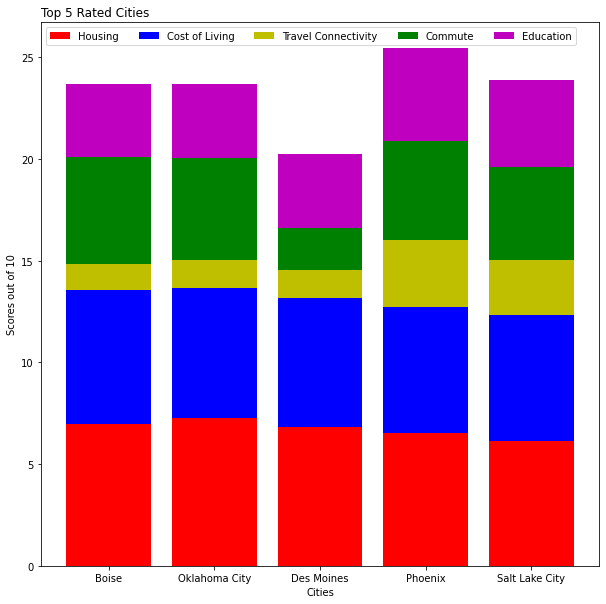

In [74]:

fig, ax = plt.subplots(1, figsize=(10, 10))
# create data
x = top_5_total['City']
y1 = top_5_total['Housing']
y2 = top_5_total['Cost of Living']
y3 = top_5_total['Travel Connectivity']
y4 = top_5_total['Commute']
y5 = top_5_total['Education']
  
# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='y')
plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.bar(x, y5, bottom=y1+y2+y3+y4, color='m')
plt.xlabel("Cities")
plt.ylabel("Scores out of 10")
plt.legend(["Housing", "Cost of Living", "Travel Connectivity", "Commute", "Education"],loc='upper left', ncol = 5)
plt.title("Top 5 Rated Cities", loc ='left')
fig.align_labels()
plt.savefig("Top5CityScores.png")
plt.show()


# Stacked Bar Graph of Bottom 5 Rated Cities and Scores

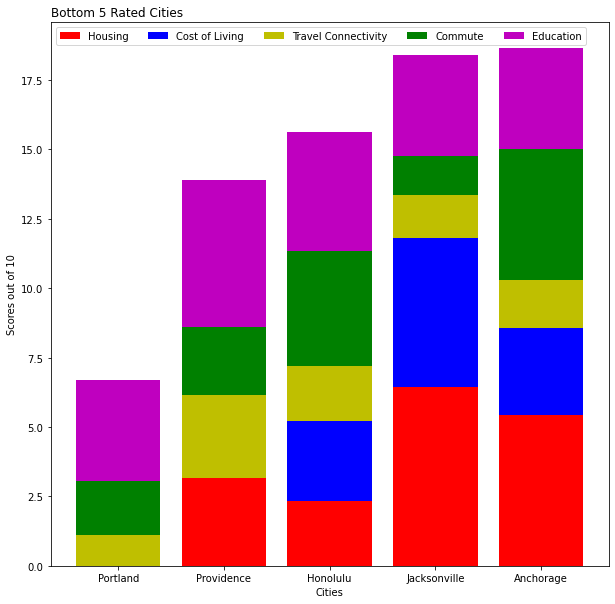

In [75]:

fig, ax = plt.subplots(1, figsize=(10, 10))
# create data
x = bottom_5_total['City']
y1 = bottom_5_total['Housing']
y2 = bottom_5_total['Cost of Living']
y3 = bottom_5_total['Travel Connectivity']
y4 = bottom_5_total['Commute']
y5 = bottom_5_total['Education']
  
# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='y')
plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.bar(x, y5, bottom=y1+y2+y3+y4, color='m')
plt.xlabel("Cities")
plt.ylabel("Scores out of 10")
plt.legend(["Housing", "Cost of Living", "Travel Connectivity", "Commute", "Education"],loc='upper left', ncol = 5)
plt.title("Bottom 5 Rated Cities", loc ='left')
fig.align_labels()
plt.savefig("Bottom5CityScores.png")
plt.show()


In [76]:
# Stacked Bar Graph of Top 5 vs Bottom 5 Rated Cities and Scores

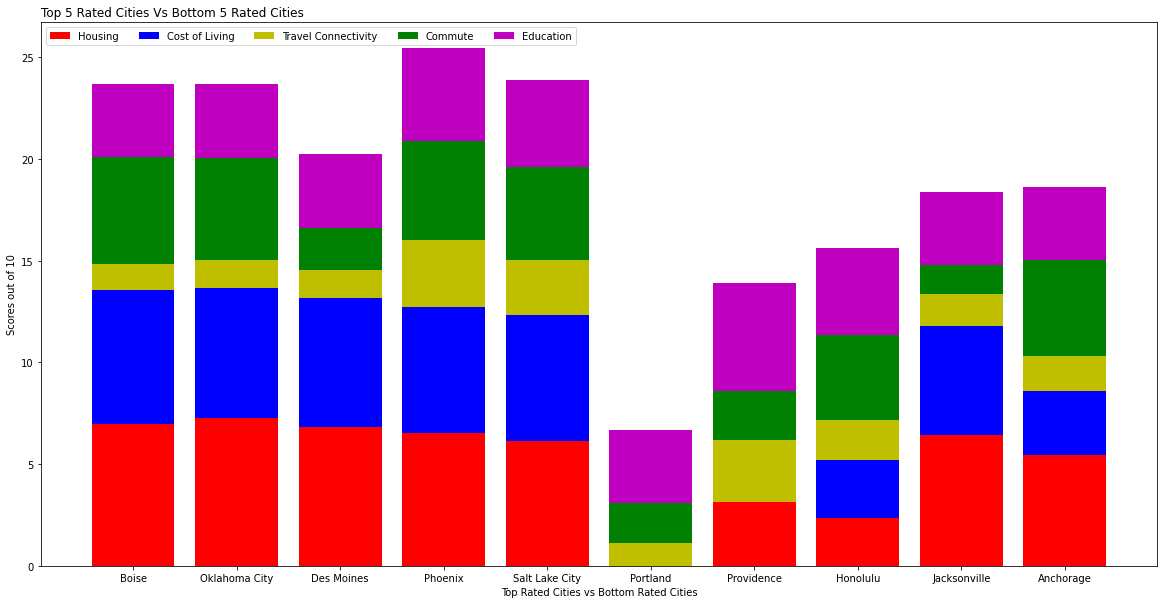

In [77]:
fig, ax = plt.subplots(1, figsize=(20,10))
# create data
x = topvsbottom['City']
y1 = topvsbottom['Housing']
y2 = topvsbottom['Cost of Living']
y3 = topvsbottom['Travel Connectivity']
y4 = topvsbottom['Commute']
y5 = topvsbottom['Education']
  
# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='y')
plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.bar(x, y5, bottom=y1+y2+y3+y4, color='m')
plt.xlabel("Top Rated Cities vs Bottom Rated Cities")
plt.ylabel("Scores out of 10")
plt.legend(["Housing", "Cost of Living", "Travel Connectivity", "Commute", "Education"],loc='upper left', ncol = 5)
plt.title("Top 5 Rated Cities Vs Bottom 5 Rated Cities", loc ='left')
fig.align_labels()
plt.savefig("TopvsBottom5CityScores.png")
plt.show()


In [83]:
tot_percent=qol_df['Total Score']/qol_df['Total Score'].sum()
tot_percent=tot_percent*100
tot_percent = tot_percent.sort_values()
tot_percent

16    0.868318
30    1.801661
8     2.027112
6     2.386666
0     2.418498
1     2.433669
34    2.490007
5     2.559020
19    2.595520
31    2.612311
9     2.626153
28    2.648487
21    2.684890
13    2.705733
4     2.766610
14    2.787064
12    2.840744
20    2.849140
35    2.895105
3     2.897115
29    2.897310
17    2.936468
18    3.050182
22    3.063893
25    3.063893
27    3.073748
10    3.074882
26    3.082435
33    3.099518
23    3.109859
15    3.149989
32    3.200558
24    3.205323
2     3.301597
7     3.353430
11    3.443092
Name: Total Score, dtype: float64

In [84]:
h_percent=qol_df['Housing']/qol_df['Housing'].sum()
h_percent=h_percent*100

h_percent

0     3.153887
1     3.805154
2     3.792094
3     0.886641
4     2.227485
5     0.702637
6     3.743916
7     2.888039
8     1.359129
9     3.976677
10    4.041978
11    2.148834
12    3.637113
13    3.099034
14    0.580452
15    2.803584
16    0.000000
17    3.612154
18    2.750472
19    3.893383
20    3.220929
21    4.086673
22    0.580452
23    4.215243
24    4.063745
25    0.580452
26    3.650754
27    4.214663
28    2.401911
29    2.441962
30    1.830166
31    4.129627
32    3.032572
33    3.564556
34    1.329816
35    3.553818
Name: Housing, dtype: float64

In [86]:
l_percent=qol_df['Cost of Living']/qol_df['Cost of Living'].sum()
l_percent=l_percent*100

l_percent

0     1.826694
1     2.985170
2     3.610352
3     2.649607
4     2.967142
5     2.090724
6     3.116604
7     3.047979
8     1.667345
9     3.679558
10    3.825531
11    2.771736
12    3.185810
13    2.903170
14    2.476883
15    2.897354
16    0.000000
17    3.507997
18    2.932248
19    3.398662
20    2.900262
21    3.485897
22    1.362024
23    3.523699
24    3.349229
25    1.362024
26    3.341669
27    3.718523
28    2.863623
29    2.571678
30    0.000000
31    3.389939
32    3.583600
33    3.589416
34    2.204129
35    3.213725
Name: Cost of Living, dtype: float64

In [87]:
t_percent=qol_df['Travel Connectivity']/qol_df['Travel Connectivity'].sum()
t_percent=t_percent*100

t_percent

0     1.651691
1     1.364213
2     3.138498
3     3.761921
4     4.032293
5     4.281282
6     1.489658
7     5.028724
8     1.884524
9     1.310519
10    1.257775
11    5.233997
12    1.597997
13    1.669747
14    3.055343
15    3.484422
16    1.047275
17    3.459713
18    3.368005
19    1.776185
20    3.496301
21    1.346157
22    6.343519
23    1.383220
24    3.353275
25    6.343519
26    1.580415
27    1.329526
28    2.129237
29    3.379409
30    2.868601
31    1.578990
32    4.123050
33    2.601081
34    2.741256
35    1.508665
Name: Travel Connectivity, dtype: float64

In [88]:
c_percent=qol_df['Commute']/qol_df['Commute'].sum()
c_percent=c_percent*100

c_percent

0     3.301331
1     1.414806
2     3.380622
3     2.574412
4     3.171630
5     3.120520
6     0.984221
7     2.728967
8     2.913804
9     1.450863
10    3.658227
11    3.206462
12    3.401801
13    3.239894
14    3.077987
15    3.455012
16    1.379449
17    0.653230
18    3.448185
19    1.381024
20    2.894375
21    1.489721
22    3.864243
23    3.539729
24    3.365919
25    3.864243
26    3.519424
27    3.519775
28    3.436283
29    2.892625
30    1.695737
31    1.342517
32    2.822086
33    3.202436
34    3.167254
35    3.441184
Name: Commute, dtype: float64

In [89]:
e_percent=qol_df['Education']/qol_df['Education'].sum()
e_percent=e_percent*100

e_percent

0     2.025437
1     2.025437
2     2.565535
3     4.819530
4     2.025437
5     3.335308
6     2.025437
7     3.608291
8     2.392022
9     2.025437
10    2.025437
11    4.469989
12    2.025437
13    2.320214
14    4.819530
15    3.286132
16    2.025437
17    3.251485
18    2.947488
19    2.025437
20    2.025437
21    2.306802
22    4.522797
23    2.320214
24    2.025437
25    4.522797
26    2.820636
27    2.025437
28    2.355699
29    3.368837
30    2.962576
31    2.025437
32    2.753857
33    2.392022
34    3.193368
35    2.334185
Name: Education, dtype: float64

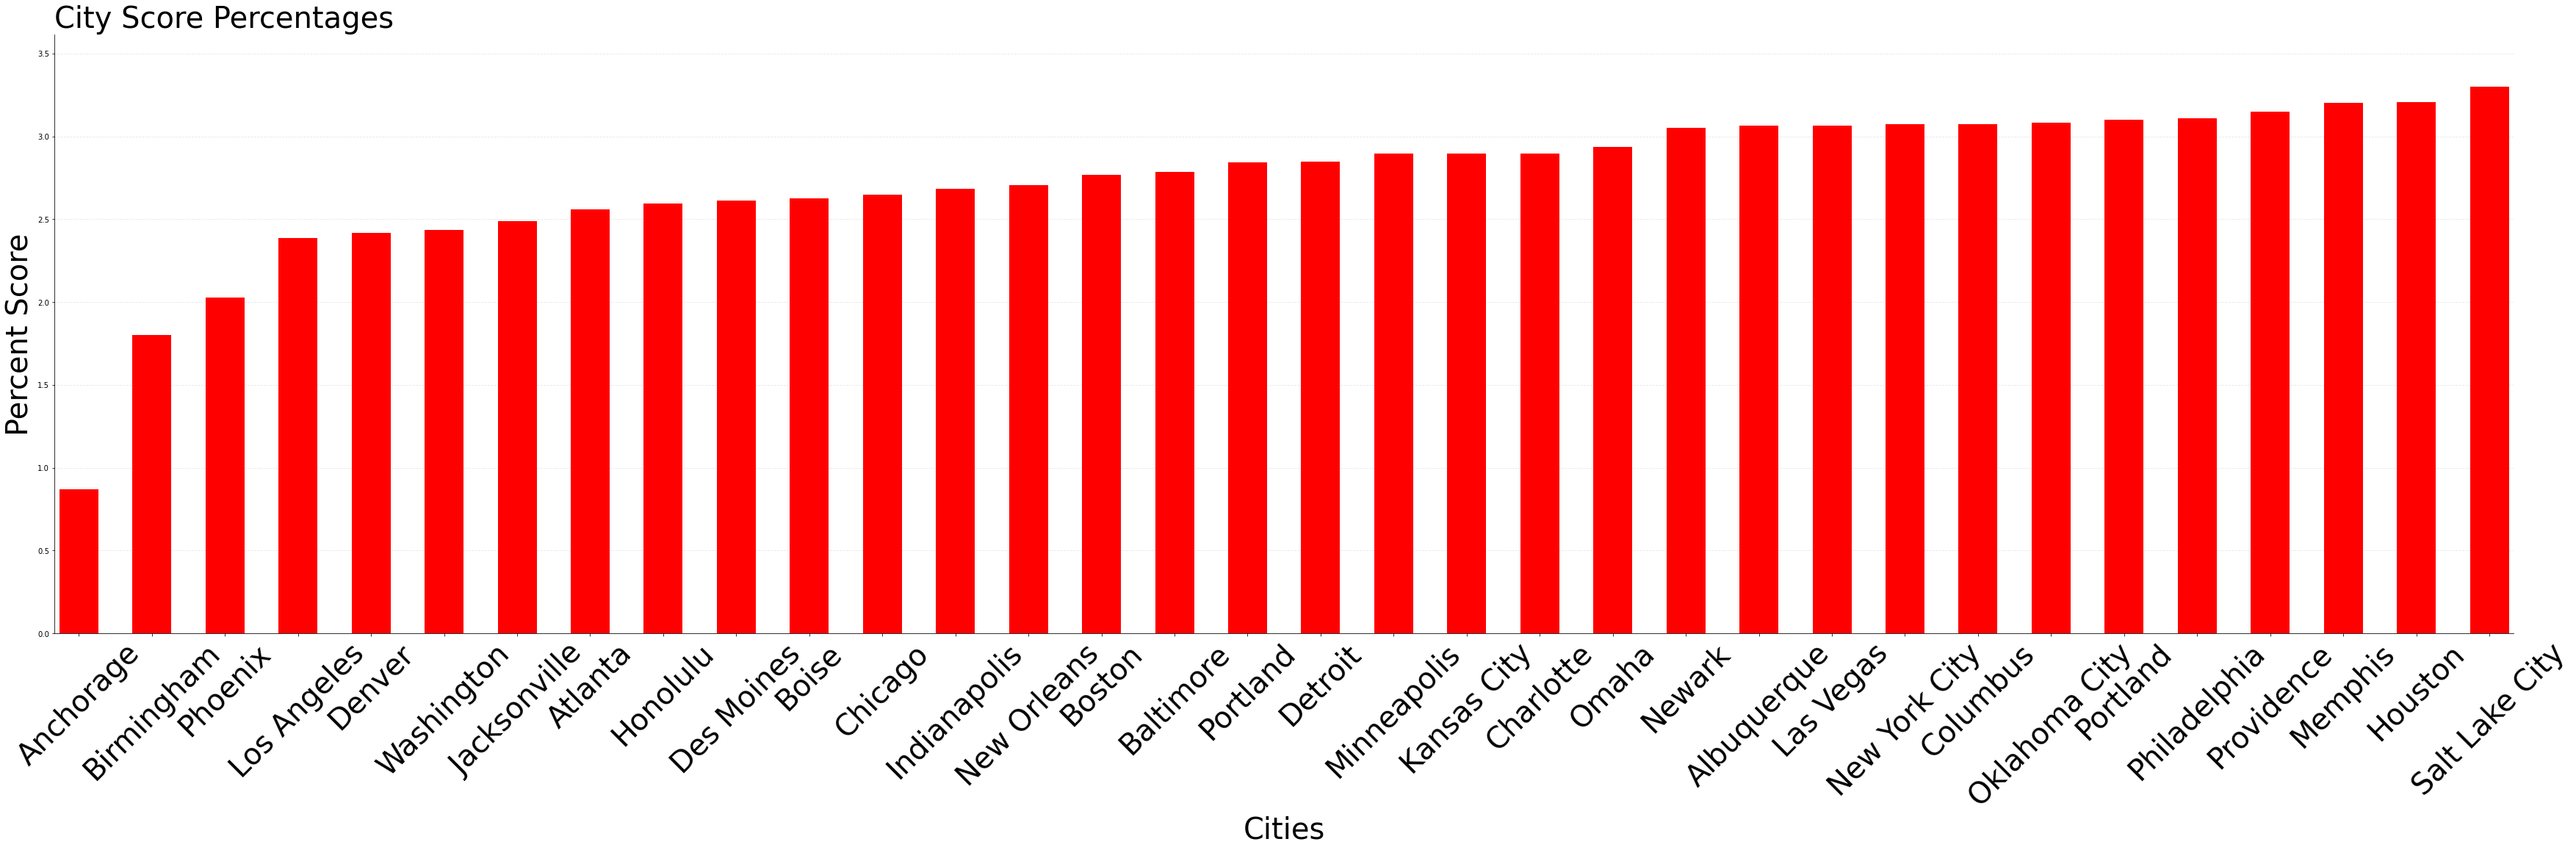

In [92]:
# define figure
fig, ax = plt.subplots(1, figsize=(60, 15))

# numerical x
x = np.arange(0, len(cities))*1.5

# plot bars
plt.bar(x, tot_percent, color = 'r')
# x1 = cities
# y1 = h_percent
# plt. plot(x1, y1, label = "line 1")
# x2 = cities
# y2 = l_percent
# plt. plot(x2, y2, label = "line 2")
# plt. xlabel('x - axis')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# x y details
plt.ylabel('Percent Score', fontsize=40)
plt.xlabel("Cities", fontsize=40)
plt.xticks(x, cities, rotation = 45, fontsize=40)
plt.xlim(-.5, 50)

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.2)

# title and legend
plt.title('City Score Percentages', loc ='left', fontsize= 40)

plt.savefig("PercentScore.png")
fig.align_labels()

fig.align_labels()
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees

plt.show()
